In [1]:
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

# Quaternions for rotation in python

In a paper from the 90s that formed the pre-cursor to several ligand volume-overlap techniques today ([doi](https://doi.org/10.1002/(SICI)1096-987X(19961115)17:14<1653::AID-JCC7>3.0.CO;2-K)), Grant et al use quaternions to handle rotations while maximizing the overlap between two ligands: 

>The rotational part of  the problem is solved using  a  quaternion formulation of  the parameters specifying the rotations. This replaces the Euler angles usually used to specify rotations by four real parameters and a constraint. The Euler angles have a plane of  singularities that reduce the efficiency of  minimization techniques and give rise to artificial saddle points and minima, a problem not encountered when using the purely algebraic quaternion parameters.

Using quaternions is common in computer graphics settings and robotics but is also clearly useful for molecular modelling! Apart from the singularities occurring when using trig functions, quaternions are cheaper to use: multiple rotations can be stacked by multiplying the quaternions, which is cheaper than performing the successive matrix multiplications required for trigonometric rotation matrices. 

There's a nice introduction to the maths of quaternions [here](https://www.3dgep.com/understanding-quaternions/), but its not immediately obvious how they work in practice. Here I reverse engineered the pyquaternion package to demonstrate how to use them. 

Since this notebook is focused on practical usage, a simple practical definition that is mathematically imprecise is: 
_a quaternion is an array of four numbers, one a scalar and three with some 'complex number' character. The multiplication rules for the complex numbers help to express a quaternion as a rotation matrix of scalars without using trig._ 


# Normalizing

Grant et al claim that using a quaternion for rotation, plus three parameters for translation in the x,y, and z axes, leads to 6 total parameters. How does that work if a quaternion has four components? This is explained on [3dgep](https://www.3dgep.com/understanding-quaternions/):

>Quaternions only require 4 numbers (3 if they are normalized. The Real part can be computed at run-time) to represent a rotation where a matrix requires at least 9 values.


The pyquaternion package demonstrates how to normalize (see below). 

This means, when optimizing a rotation, only the last three of the four components need to be optimised. The first component, the scalar, results from normalising on the fly. 




In [2]:
def fast_normalise(q):
    """
    https://github.com/KieranWynn/pyquaternion/blob/99025c17bab1c55265d61add13375433b35251af/pyquaternion/quaternion.py#L513
    Normalise the object to a unit quaternion using a fast approximation method if appropriate.
    Object is guaranteed to be a quaternion of approximately unit length
    after calling this operation UNLESS the object is equivalent to Quaternion(0)
    """

    mag_squared = np.dot(q, q)
    if (mag_squared == 0):
        return
    if (abs(1.0 - mag_squared) < 2.107342e-08):
        mag =  ((1.0 + mag_squared) / 2.0) # More efficient. Pade approximation valid if error is small
    else:
        mag =  np.sqrt(mag_squared) # Error is too big, take the performance hit to calculate the square root properly

    return q / mag


#example quarternion:
quart = np.array([0.9, -0.3, 0.7, 0.3])
print(f'Unnormalized: {quart},\nNormalized: {fast_normalise(quart)}')

Unnormalized: [ 0.9 -0.3  0.7  0.3],
Normalized: [ 0.73979544 -0.24659848  0.57539646  0.24659848]


# Rotating
Quaternions represent a rotation in 3d space. Rotating 3-vectors and matrices (shape `N,3`) using a quaternion uses the Hamilton product in maths-focused definitions. In practice we can just construct a rotation matrix from the quaternion, then rotate the vector or matrix with the dot product. 

The code for this comes from [here](https://automaticaddison.com/how-to-convert-a-quaternion-to-a-rotation-matrix/) - it was slightly faster than PyQuaternion so I'll stick with this going forward. 

One nice thing about this is it looks like it can be differentiated using jax.grad.

In [3]:
def quaternion_rotation_matrix(Q):
    """
    https://automaticaddison.com/how-to-convert-a-quaternion-to-a-rotation-matrix/
    Covert a quaternion into a full three-dimensional rotation matrix.

    Input
    :param Q: A 4 element array representing the quaternion (q0,q1,q2,q3) 

    Output
    :return: A 3x3 element matrix representing the full 3D rotation matrix. 
             This rotation matrix converts a point in the local reference 
             frame to a point in the global reference frame.
    """
    # Extract the values from Q
    q0 = Q[0]
    q1 = Q[1]
    q2 = Q[2]
    q3 = Q[3]
    
    # First row of the rotation matrix
    r00 = 2 * (q0 * q0 + q1 * q1) - 1
    r01 = 2 * (q1 * q2 - q0 * q3)
    r02 = 2 * (q1 * q3 + q0 * q2)
    
    # Second row of the rotation matrix
    r10 = 2 * (q1 * q2 + q0 * q3)
    r11 = 2 * (q0 * q0 + q2 * q2) - 1
    r12 = 2 * (q2 * q3 - q0 * q1)
    
    # Third row of the rotation matrix
    r20 = 2 * (q1 * q3 - q0 * q2)
    r21 = 2 * (q2 * q3 + q0 * q1)
    r22 = 2 * (q0 * q0 + q3 * q3) - 1
    
    # 3x3 rotation matrix
    rot_matrix = np.array([[r00, r01, r02],
                           [r10, r11, r12],
                           [r20, r21, r22]]) 
    return rot_matrix


In [4]:
point = np.array([0,0,1])

quart = np.array([0.9, -0.3, 0.7, 0.3])
nq = fast_normalise(quart)
print('Normalized quaternion:\n', nq)

rotmat = quaternion_rotation_matrix(nq)
print('\nRotation matrix:\n', rotmat)

print('\nPoint before rotation:\n', point)

print('\nPoint after rotation:\n', point.dot(rotmat))


Normalizd quaternion:
 [ 0.73979544 -0.24659848  0.57539646  0.24659848]

Rotation matrix:
 [[ 0.21621622 -0.64864865  0.72972973]
 [ 0.08108108  0.75675676  0.64864865]
 [-0.97297297 -0.08108108  0.21621622]]

Point before rotation:
 [0 0 1]

Point after rotation:
 [-0.97297297 -0.08108108  0.21621622]


# Visualize it:
Definitely something happened! It's not exactly clear what, though. So the following visualizes it with a neater example:

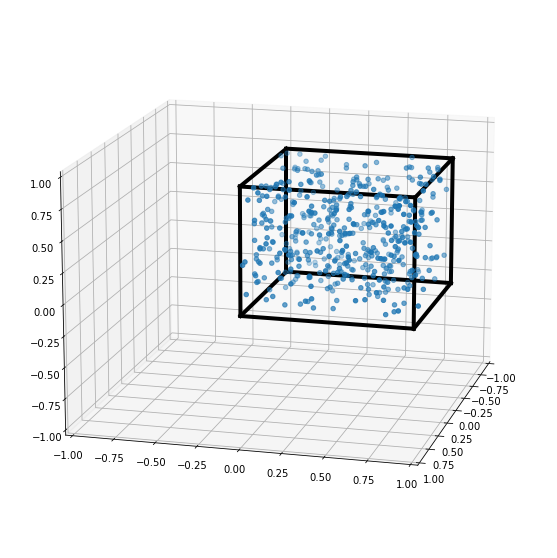

In [5]:
#These functions draw cube outlines and cube points:
def draw_cbl(cbl, ax, c="k"):
    """Draws the lines surrounding a cube"""
    for s, e in zip(cbl[::2], cbl[1::2]):
        ax.plot3D(*zip(s, e), color=c, linewidth=4,zorder=1)

def draw_cb(cb, ax, c="C0"):
    """Draws the points within a cube"""
    ax.scatter(cb[:,0], cb[:,1], cb[:,2], 
               marker='o', 
               color=c,
               zorder=0)

#prepare the outlines of a cube:

cubelines = list()
r = [0, 1]
for s, e in itertools.combinations(np.array(list(itertools.product(r, r, r))), 2):
    if np.sum(np.abs(s-e)) == r[1]-r[0]:
        cubelines.append(s)
        cubelines.append(e)

cubelines=np.array(cubelines)

#sample some points in the cube:
cubepts = np.random.uniform(0,1,[500,3])



#now draw an example unit cube:
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(10)
ax = fig.add_subplot(111, projection='3d')


draw_cb(cubepts, ax)
draw_cbl(cubelines,ax)

ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)
ax.view_init(15, 15)


Now rotate it using a quaternion. 
Success! The cube rotates. Mess with the quaternion to get different rotations.

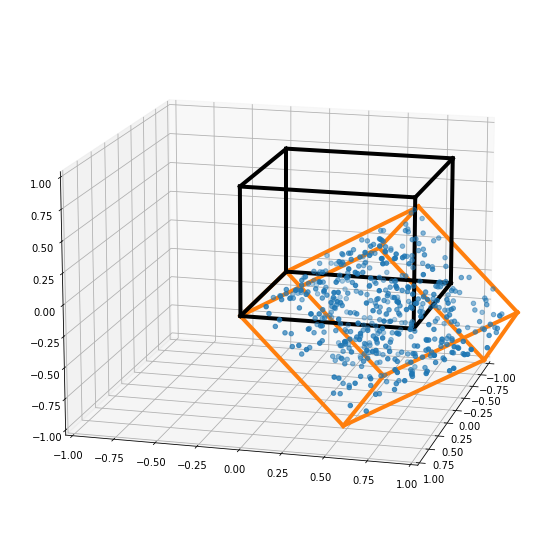

In [6]:

quart = np.array([1, 0.5, 0.0, 0])
nq = fast_normalise(quart)
rotmat = quaternion_rotation_matrix(nq)

fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(10)

ax = fig.add_subplot(111, projection='3d')


draw_cb(cubepts.dot(rotmat), ax)
draw_cbl(cubelines.dot(rotmat),ax,c="C1")

draw_cbl(cubelines,ax)

ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)
ax.view_init(15, 15)

# Now find a good 'starting' quaternion
Without a rigorous description of quaternions, it's a bit of a crapshoot to know what values to use. Ultimately, though, a minimizing algorithm won't care - it just knows that the bounds on the complex parts are [-1,1]. 

Most minimizing procedures begin close to the global optimum by aligning the molecules by their principal moments of inertia. We wouldn't want to suddenly flip the molecule away from that starting point, so let's identify the quaternion that corresponds to zero rotation away from the starting point. That would be a good initialisation for any volume overlap maximisation approach. 

To do this, the below uses a rotation matrix corresponding to zero rotation, and works backwards to identify the quaternion. 

In [7]:
def trace_method(matrix):
    """
    https://github.com/KieranWynn/pyquaternion/blob/master/pyquaternion/quaternion.py#L205
    """
    m = matrix.conj().transpose() # This method assumes row-vector and postmultiplication of that vector
    if m[2, 2] < 0:
        if m[0, 0] > m[1, 1]:
            t = 1 + m[0, 0] - m[1, 1] - m[2, 2]
            q = [m[1, 2]-m[2, 1],  t,  m[0, 1]+m[1, 0],  m[2, 0]+m[0, 2]]
        else:
            t = 1 - m[0, 0] + m[1, 1] - m[2, 2]
            q = [m[2, 0]-m[0, 2],  m[0, 1]+m[1, 0],  t,  m[1, 2]+m[2, 1]]
    else:
        if m[0, 0] < -m[1, 1]:
            t = 1 - m[0, 0] - m[1, 1] + m[2, 2]
            q = [m[0, 1]-m[1, 0],  m[2, 0]+m[0, 2],  m[1, 2]+m[2, 1],  t]
        else:
            t = 1 + m[0, 0] + m[1, 1] + m[2, 2]
            q = [t,  m[1, 2]-m[2, 1],  m[2, 0]-m[0, 2],  m[0, 1]-m[1, 0]]

    q = np.array(q).astype('float64')
    q *= 0.5 / np.sqrt(t)
    return q

In [8]:
#construct a rotation matrix that does nothing:
zero_rot_mat = np.array([[1,0,0], [0,1,0], [0,0,1]])

In [9]:
#turn it back into a quaternion:
trace_method(zero_rot_mat)

array([1., 0., 0., 0.])

In [10]:
#sanity check: does this quaternion indeed return the zero-rotation matrix?
#yes.
quaternion_rotation_matrix(trace_method(zero_rot_mat))

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

# Try it on a molecule.
This loads a Mol3D (a convenience class for working with 3d-embedded molecules in rdkit), translates it to the origin, and visualizes with py3Dmol.

In [11]:
from mol3d import Mol3D
import py3Dmol
from rdkit import Chem
    
mol = Mol3D('CC(C)N1C[C@H](C)[C@H](NC(=O)N2Cc3ccccc3[C@@H]2C)C1')

In [12]:
#give it some 3d coordinates:
mol.embed3d(1)
#translate to the origin
mol.set_pos(mol.get_pos(0) - mol.get_pos(0).min(0))

p_O3A = py3Dmol.view(width=600, height=400)
p_O3A.addModel(Chem.MolToMolBlock(mol.mol), 'sdf')
p_O3A.setStyle({'stick':{'colorscheme':'cyanCarbon'}})
p_O3A.render()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

# Now rotate it:

To drive home the point, this just makes lots of random rotations. We would expect to see a sphere-shaped collection of super-imposed molecules. 

In [13]:
p_O3A = py3Dmol.view(width=600, height=400)
p_O3A.addModel(Chem.MolToMolBlock(mol.mol), 'sdf')


for i in range(150):
    
    q = np.random.uniform(-1,1, [4])
    n = fast_normalise(q)

    #set the coordinates of the molecule:
    mol.set_pos(mol.get_pos(0).dot(quaternion_rotation_matrix(n)))
    
    p_O3A.addModel(Chem.MolToMolBlock(mol.mol), 'sdf')

p_O3A.setStyle({'stick':{'colorscheme':'cyanCarbon'}})
p_O3A.render()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

# Wrap it up in a class for use later
This generates a quaternion class using the code from above. The only new thing added here is the ability to create a quaternion by axis rotation, which will be used later for constructing multiple rotations in one hit.

In [2]:
class QT(object):
    def __init__(self q):
        self.q q
        
    def fast_normalise(self):
        """
        normalize an array of four values to unit length in quaternion space.
        credit:https://github.com/KieranWynn/pyquaternion/blob/99025c17bab1c55265d61add13375433b35251af/pyquaternion/quaternion.py#L513
        """

        mag_squared = np.dot(self.q, self.q)
        if (mag_squared == 0):
            return
        if (abs(1.0 - mag_squared) < 2.107342e-08):
            mag =  ((1.0 + mag_squared) / 2.0) # More efficient. Pade approximation valid if error is small
        else:
            mag =  np.sqrt(mag_squared) # Error is too big, take the performance hit to calculate the square root properly

        return self.q / mag

    def quaternion_rotation_matrix(self):
        """
        generate a rotation matrix from a quaternion
        credit:https://automaticaddison.com/how-to-convert-a-quaternion-to-a-rotation-matrix/

        """
        # Extract the values from Q
        q0 = self.q[0]
        q1 = self.q[1]
        q2 = self.q[2]
        q3 = self.q[3]
        # First row of the rotation matrix
        r00 = 2 * (q0 * q0 + q1 * q1) - 1
        r01 = 2 * (q1 * q2 - q0 * q3)
        r02 = 2 * (q1 * q3 + q0 * q2)
        # Second row of the rotation matrix
        r10 = 2 * (q1 * q2 + q0 * q3)
        r11 = 2 * (q0 * q0 + q2 * q2) - 1
        r12 = 2 * (q2 * q3 - q0 * q1)
        # Third row of the rotation matrix
        r20 = 2 * (q1 * q3 - q0 * q2)
        r21 = 2 * (q2 * q3 + q0 * q1)
        r22 = 2 * (q0 * q0 + q3 * q3) - 1
        # 3x3 rotation matrix
        rot_matrix = np.array([[r00, r01, r02],
                               [r10, r11, r12],
                               [r20, r21, r22]]) 
        return rot_matrix
    
    
    def trace_method(matrix):
        """
        credit: https://github.com/KieranWynn/pyquaternion/blob/master/pyquaternion/quaternion.py#L205
        """
        m = matrix.conj().transpose() # This method assumes row-vector and postmultiplication of that vector
        if m[2, 2] < 0:
            if m[0, 0] > m[1, 1]:
                t = 1 + m[0, 0] - m[1, 1] - m[2, 2]
                q = [m[1, 2]-m[2, 1],  t,  m[0, 1]+m[1, 0],  m[2, 0]+m[0, 2]]
            else:
                t = 1 - m[0, 0] + m[1, 1] - m[2, 2]
                q = [m[2, 0]-m[0, 2],  m[0, 1]+m[1, 0],  t,  m[1, 2]+m[2, 1]]
        else:
            if m[0, 0] < -m[1, 1]:
                t = 1 - m[0, 0] - m[1, 1] + m[2, 2]
                q = [m[0, 1]-m[1, 0],  m[2, 0]+m[0, 2],  m[1, 2]+m[2, 1],  t]
            else:
                t = 1 + m[0, 0] + m[1, 1] + m[2, 2]
                q = [t,  m[1, 2]-m[2, 1],  m[2, 0]-m[0, 2],  m[0, 1]-m[1, 0]]

        q = np.array(q).astype('float64')
        q *= 0.5 / np.sqrt(t)
        return q
    
    def rot_along_axis()